In [1]:
# -*- coding: utf-8 -*-

In [2]:
import re
import os
import sys
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as pp
%matplotlib inline
import numpy as np
import json
from scipy import stats
import csv
import pprint
from collections import defaultdict
import time
import datetime
import math

from getMisogynyLexicon import *
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

In [3]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATE = "28/09/2018"
quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

TREATMENT_COMMENTS_FOLDER = "/mnt/storage/quarantine/data/"
TREATMENT_SUBMISSIONS_FOLDER = "/mnt/storage/quarantine/data/"

In [4]:
###load files and preprocess dataframes
def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

def load_data(subreddit, COMMENTS_FOLDER, SUBMISSIONS_FOLDER):
    comments_data = pd.read_csv(COMMENTS_FOLDER + subreddit + "-comments.csv")
    submissions_data = pd.read_csv(SUBMISSIONS_FOLDER + subreddit + "-submissions.csv")
    return comments_data, submissions_data

def preprocess_data(comments_data, submissions_data):
    ###preprocessing - retain only columns of importance
    comments_data = comments_data[['author', 'created_utc', 'body']]
    submissions_data = submissions_data[['author', 'created_utc', 'title', 'selftext']]
    
    ###make the column names the same
    submissions_data.rename(columns={'title': 'body'}, inplace=True)
    comments_data['selftext'] = 'EMPTY'
    comments_data['type'] = 'comment'
    submissions_data['type'] = 'submission'
    
    ###merge comments + submissions; remove rows with null author or created_utc
    subreddit_timeline = pd.concat([comments_data, submissions_data], ignore_index=True, sort=True)
    subreddit_timeline = subreddit_timeline.dropna(subset=['author', 'created_utc'])
    
    ###typecasting to prevent errors
    subreddit_timeline = subreddit_timeline[pd.to_numeric(subreddit_timeline['created_utc'], errors='coerce').notnull()]
    subreddit_timeline['author']=subreddit_timeline.author.astype('str')
    subreddit_timeline['body']=subreddit_timeline.body.astype('str')
    subreddit_timeline['selftext']=subreddit_timeline.selftext.astype('str')
    subreddit_timeline['created_utc']=subreddit_timeline.created_utc.astype('float')
    subreddit_timeline['type']=subreddit_timeline.type.astype('str')
    
    ###compute time variables for ITS
    subreddit_timeline['post_treatment'] = subreddit_timeline['created_utc'] > quarDataUnix
    subreddit_timeline['time'] = subreddit_timeline['created_utc'].apply(getTimeChunkIndex)
    
    return subreddit_timeline

def get_effect(coeff):
    return np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

In [5]:
subreddit = 'TheRedPill'
comments_data, submissions_data = load_data(subreddit, TREATMENT_COMMENTS_FOLDER, TREATMENT_SUBMISSIONS_FOLDER)
subreddit_timeline = preprocess_data(comments_data, submissions_data)    

/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/ipykernel_launch

# Comparing pre- and post-quarantine TRP activity on use of misogynistic sub-categories of speech

In [6]:
CATEGORY_NAMES, CATEGORY_WORDS = get_lexicon()
misogyny_lexicon = list()
cv = {}

for key in CATEGORY_WORDS:
    category = CATEGORY_NAMES[key]
    category_lexicon = CATEGORY_WORDS[key]
    sage_lex = pd.DataFrame()
    sage_lex['word'] = category_lexicon
    cv[category] = CountVectorizer(vocabulary = sage_lex.word)

    ##tokenizer to get the number of words in the sentence
tokenizer = RegexpTokenizer(r'\w+')
categories = list(cv.keys())

In [7]:
TrpMisogynyCount = {}
TotalWordCount = {}
for category in categories:
    TrpMisogynyCount[category] = {}
    TotalWordCount[category] = {}

In [8]:
len(subreddit_timeline)

243758

In [9]:
count = 0
for i, row in subreddit_timeline.iterrows():
    count += 1
    if (count % 10000 == 0):
        print (count)
    body = row['body']
    selftext = row['selftext']
    postTime = row['created_utc']
    timeChunkIndex = getTimeChunkIndex(postTime)

    lis = []
    if row['type'] == "submission":
        lis.append(selftext)
    else:
        lis.append(body)

    for category in categories:
        arr = cv[category].fit_transform(lis).toarray()
        hate_iter = np.sum(arr)

        if timeChunkIndex in TrpMisogynyCount[category]:
            TrpMisogynyCount[category][timeChunkIndex] += hate_iter
        else:
            TrpMisogynyCount[category][timeChunkIndex] = hate_iter

    totalWords_iter = len(tokenizer.tokenize(lis[0]))            
    if timeChunkIndex in TotalWordCount:
        TotalWordCount[timeChunkIndex] += totalWords_iter
    else:
        TotalWordCount[timeChunkIndex] = totalWords_iter

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


In [10]:
myColors = ['black', 'gray', 'red', 'gold', 'darkgreen', 'navy', 'blue', 'violet', 'pink']

 
Category:  Belitting
                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     -0.060    
Dependent Variable:  counts           AIC:                -526.9993 
Date:                2019-09-15 23:55 BIC:                -522.2487 
No. Observations:    36               Log-Likelihood:     266.50    
Df Model:            2                F-statistic:        0.003571  
Df Residuals:        33               Prob (F-statistic): 0.996     
R-squared:           0.000            Scale:              2.3733e-08
--------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------
Intercept              0.0010   0.0001 17.2283 0.0000  0.0009 0.0011
post_treatment[T.True] 0.0000   0.0001  0.0265 0.9790 -0.0002 0.0002
time                   0.0000   0.0000  0.0171 0.9864 -0.0000 0.0000
------------------------------

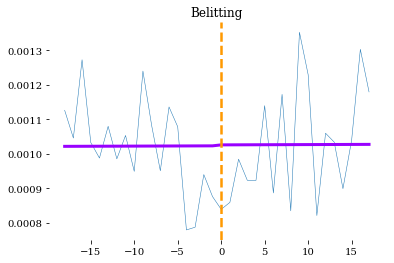

Coefficient =  2.724818151302738e-06 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Flipping the narrative
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.043     
Dependent Variable:   counts           AIC:                -514.8002 
Date:                 2019-09-15 23:55 BIC:                -510.0497 
No. Observations:     36               Log-Likelihood:     260.40    
Df Model:             2                F-statistic:        1.794     
Df Residuals:         33               Prob (F-statistic): 0.182     
R-squared:            0.098            Scale:              3.3306e-08
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0006   0.0001  8.8296 0.0000  0.0005 0.0008
post_treatment[T.Tr

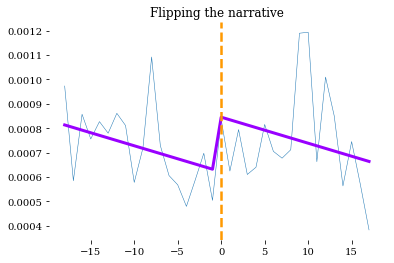

Coefficient =  0.00022394618072550155 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Homophobia
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     -0.058    
Dependent Variable:   counts           AIC:                -658.5066 
Date:                 2019-09-15 23:55 BIC:                -653.7561 
No. Observations:     36               Log-Likelihood:     332.25    
Df Model:             2                F-statistic:        0.03534   
Df Residuals:         33               Prob (F-statistic): 0.965     
R-squared:            0.002            Scale:              6.1501e-10
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0001   0.0000  6.6038 0.0000  0.0000 0.0001
post_treatment[T.True]  0.0000

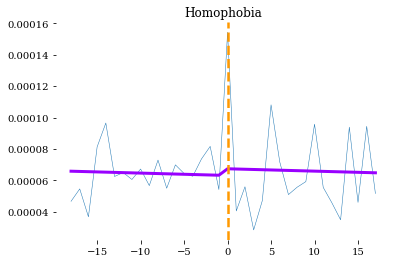

Coefficient =  4.253747893169583e-06 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Hostility
                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.160     
Dependent Variable:  counts            AIC:                 -505.7338 
Date:                2019-09-15 23:55  BIC:                 -500.9833 
No. Observations:    36                Log-Likelihood:      255.87    
Df Model:            2                 F-statistic:         4.331     
Df Residuals:        33                Prob (F-statistic):  0.0214    
R-squared:           0.208             Scale:               4.2844e-08
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.0025   0.0001 31.1142 0.0000  0.0023  0.0026
post_treatment[T.True

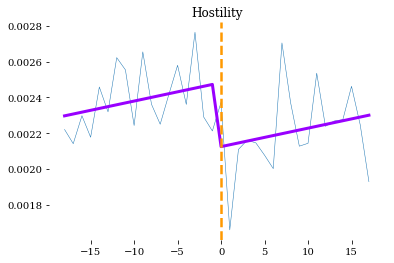

Coefficient =  -0.00035862970353066635 Effect =  -0.0 %
 ******************************************************************** 
 
Category:  Patriarchy
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     -0.045    
Dependent Variable:   counts           AIC:                -670.7615 
Date:                 2019-09-15 23:55 BIC:                -666.0109 
No. Observations:     36               Log-Likelihood:     338.38    
Df Model:             2                F-statistic:        0.2544    
Df Residuals:         33               Prob (F-statistic): 0.777     
R-squared:            0.015            Scale:              4.3756e-10
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0000   0.0000  4.2016 0.0002  0.0000 0.0001
post_treatment[T.True]  0.00

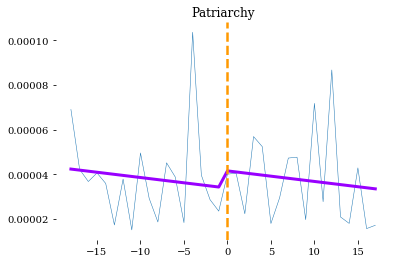

Coefficient =  7.695699289361192e-06 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Physical Violence
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.073     
Dependent Variable:   counts           AIC:                -542.7545 
Date:                 2019-09-15 23:55 BIC:                -538.0040 
No. Observations:     36               Log-Likelihood:     274.38    
Df Model:             2                F-statistic:        2.388     
Df Residuals:         33               Prob (F-statistic): 0.107     
R-squared:            0.126            Scale:              1.5321e-08
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0012   0.0000 25.0067 0.0000  0.0011 0.0013
post_treatment[T.True]  

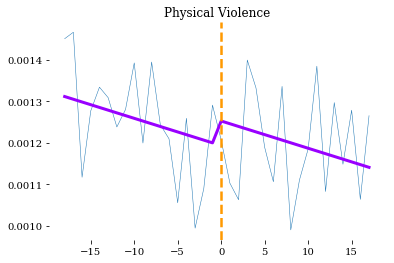

Coefficient =  5.926366945173029e-05 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Racism
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.027     
Dependent Variable:   counts           AIC:                -571.7875 
Date:                 2019-09-15 23:55 BIC:                -567.0369 
No. Observations:     36               Log-Likelihood:     288.89    
Df Model:             2                F-statistic:        1.480     
Df Residuals:         33               Prob (F-statistic): 0.242     
R-squared:            0.082            Scale:              6.8397e-09
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0004   0.0000 11.2506 0.0000  0.0003 0.0004
post_treatment[T.True] -0.0001   0.

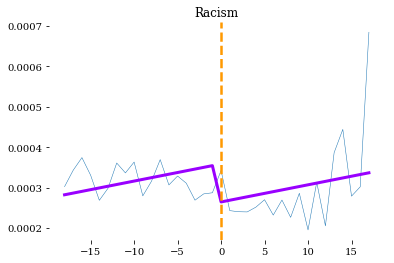

Coefficient =  -9.401814493537026e-05 Effect =  -0.0 %
 ******************************************************************** 
 
Category:  Sexual Violence
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.027     
Dependent Variable:   counts           AIC:                -561.1184 
Date:                 2019-09-15 23:55 BIC:                -556.3678 
No. Observations:     36               Log-Likelihood:     283.56    
Df Model:             2                F-statistic:        1.488     
Df Residuals:         33               Prob (F-statistic): 0.241     
R-squared:            0.083            Scale:              9.1992e-09
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0002   0.0000  4.4274 0.0001  0.0001 0.0002
post_treatment[T.True]  

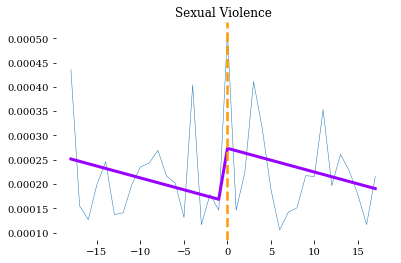

Coefficient =  0.00010971763731241732 Effect =  1.0 %
 ******************************************************************** 
 
Category:  Stoicism
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.020     
Dependent Variable:   counts           AIC:                -528.5506 
Date:                 2019-09-15 23:55 BIC:                -523.8000 
No. Observations:     36               Log-Likelihood:     267.28    
Df Model:             2                F-statistic:        1.357     
Df Residuals:         33               Prob (F-statistic): 0.271     
R-squared:            0.076            Scale:              2.2732e-08
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0008   0.0001 12.9658 0.0000  0.0006 0.0009
post_treatment[T.True] -0.0002  

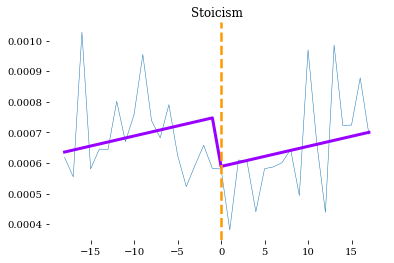

Coefficient =  -0.00016523119310554786 Effect =  -0.0 %
 ******************************************************************** 


In [52]:
import matplotlib
for category in categories:    
    print (" ")
    print ("Category: ", category)
    TrpMisogynyRate = {}
    for k in TrpMisogynyCount[category]:
        if TotalWordCount[k] == 0:
            TrpMisogynyRate[k] = 0
        else:      
            TrpMisogynyRate[k] = float(TrpMisogynyCount[category][k])/(TotalWordCount[k])            

    TrpMisogynyRate_df = pd.DataFrame()
    TrpMisogynyRate_df['time'] = TrpMisogynyRate.keys()
    TrpMisogynyRate_df['counts'] = TrpMisogynyRate.values()
    TrpMisogynyRate_df['post_treatment'] = TrpMisogynyRate_df['time'] >= 0

    # ITS
    model = smf.ols('counts ~ time + post_treatment',data = TrpMisogynyRate_df)
    results = model.fit()

    print(results.summary2())
    
    for spine in pp.gca().spines.values():
        spine.set_visible(False)  
        
    matplotlib.rcParams['font.family'] = 'serif'

    # fitted values
    TrpMisogynyRate_df['fit'] = (results.fittedvalues)
    # TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
    ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='counts',linewidth=0.5)
    ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='fit', ax = ax, linewidth=3,color='#9900ff')
    ax.set_title(category)
#     pp.legend(['observations','fit'])
    pp.tick_params(bottom=True, right=False)
    # plt.axvline(0)
    pp.axvline(x=0, linewidth=2.5, linestyle = '--', color='#ff9900')
#     ax.set_ylabel('%s' % (category,));    
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    coeff = results.params[1]
    pp.pause(0.05)
    print ("Coefficient = ", coeff, "Effect = ", np.ceil(100* coeff), "%") 
    print (" ******************************************************************** ")

### Result: the quarantining event clearly shifted how the TRP community engages in misogyny. This shift, however, was temporary. 

# How does quarantining affect the misogyny in different types of users?

In [47]:
authorNumPosts = defaultdict(int)
for index, row in subreddit_timeline.iterrows():
    postTime = row['time']
    author = row['author']
    if (postTime < 0):
        authorNumPosts[author] += 1

In [48]:
lightUsers = []
mediumUsers = []
powerUsers = []

for key, value in authorNumPosts.items():
    if (value < 5):
        lightUsers.append(key)
    elif (value < 100):
        mediumUsers.append(key)
    else:
        powerUsers.append(key)
        
print (len(lightUsers), len(mediumUsers), len(powerUsers))

14424 4797 148


In [49]:
def getAuthorCategory(author):
    if (author in lightUsers):
        return 'light'
    elif (author in mediumUsers):
        return 'medium'
    elif (author in powerUsers):
        return 'power'
    else:
        return None
    
AUTHOR_CATEGORIES = ['light', 'medium', 'power']    

In [50]:
TrpMisogynyCount = defaultdict(lambda: defaultdict(int))
TotalWordCount = defaultdict(lambda: defaultdict(int))

CATEGORY_NAMES, CATEGORY_WORDS = get_lexicon()
misogyny_lexicon = list()

for key in CATEGORY_WORDS:
    for word in CATEGORY_WORDS[key]:
        misogyny_lexicon.append(word)

sage_lex = pd.DataFrame()
sage_lex['word'] = misogyny_lexicon
sage_lex = sage_lex.drop_duplicates()
cv = CountVectorizer(vocabulary = sage_lex.word)

##tokenizer to get the number of words in the sentence
tokenizer = RegexpTokenizer(r'\w+')

In [51]:
for i, row in subreddit_timeline.iterrows():
    author = row['author']
    body = row['body']
    selftext = row['selftext']
    postTime = row['created_utc']
    timeChunkIndex = getTimeChunkIndex(postTime)
    authorCategory = getAuthorCategory(author)

    lis = []
    if row['type'] == "submission":
        lis.append(selftext)
    else:
        lis.append(body)

    arr = cv.fit_transform(lis).toarray()
    hate_iter = np.sum(arr)
    totalWords_iter = len(tokenizer.tokenize(lis[0]))       
    
    TrpMisogynyCount[authorCategory][timeChunkIndex] += hate_iter
    TotalWordCount[authorCategory][timeChunkIndex] += totalWords_iter

 
Category:  light users
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     -0.031    
Dependent Variable:   counts           AIC:                -427.2434 
Date:                 2019-09-03 23:27 BIC:                -422.4928 
No. Observations:     36               Log-Likelihood:     216.62    
Df Model:             2                F-statistic:        0.4696    
Df Residuals:         33               Prob (F-statistic): 0.629     
R-squared:            0.028            Scale:              3.7912e-07
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0063   0.0002 26.6906 0.0000  0.0059 0.0068
post_treatment[T.True] -0.0003   0.0004 -0.7359 0.4670 -0.0011 0.0005
time                    0.0000   0.0000  0.3226 0.7490 -0.0000 0.0000
--------------

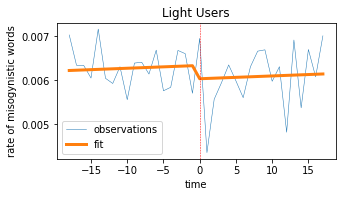

Coefficient =  -0.0003024140347363724 Effect =  -0.0 %
 ******************************************************************** 
 
Category:  medium users
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.007     
Dependent Variable:   counts           AIC:                -435.1169 
Date:                 2019-09-03 23:27 BIC:                -430.3663 
No. Observations:     36               Log-Likelihood:     220.56    
Df Model:             2                F-statistic:        1.128     
Df Residuals:         33               Prob (F-statistic): 0.336     
R-squared:            0.064            Scale:              3.0465e-07
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0069   0.0002 32.3627 0.0000  0.0065 0.0073
post_treatment[T.True] -0.0

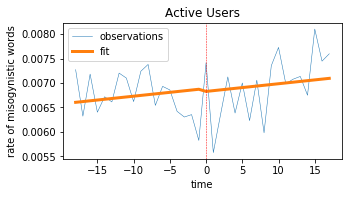

Coefficient =  -5.975659924103071e-05 Effect =  -0.0 %
 ******************************************************************** 
 
Category:  power users
                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.342     
Dependent Variable:   counts           AIC:                -413.3469 
Date:                 2019-09-03 23:27 BIC:                -408.5963 
No. Observations:     36               Log-Likelihood:     209.67    
Df Model:             2                F-statistic:        10.08     
Df Residuals:         33               Prob (F-statistic): 0.000383  
R-squared:            0.379            Scale:              5.5773e-07
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0065   0.0003 22.6187 0.0000  0.0059 0.0071
post_treatment[T.True] -0.00

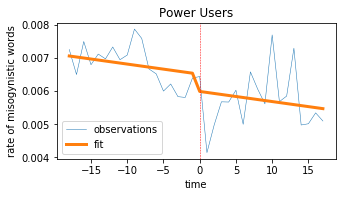

Coefficient =  -0.000520941872636831 Effect =  -0.0 %
 ******************************************************************** 


In [53]:
ts = ['Light Users', 'Active Users', 'Power Users']
count = 0
for category in AUTHOR_CATEGORIES:    
    print (" ")
    print ("Category: ", category, "users")
    TrpMisogynyRate = {}
    for k in TrpMisogynyCount[category]:
        TrpMisogynyRate[k] = float(TrpMisogynyCount[category][k])/(TotalWordCount[category][k])            

    TrpMisogynyRate_df = pd.DataFrame()
    TrpMisogynyRate_df['time'] = TrpMisogynyRate.keys()
    TrpMisogynyRate_df['counts'] = TrpMisogynyRate.values()
    TrpMisogynyRate_df['post_treatment'] = TrpMisogynyRate_df['time'] >= 0

    # ITS
    model = smf.ols('counts ~ time + post_treatment',data = TrpMisogynyRate_df)
    results = model.fit()

    print(results.summary2())

    # fitted values
    TrpMisogynyRate_df['fit'] = (results.fittedvalues)
    # TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
    ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='counts',linewidth=0.5)
    ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='fit', ax = ax, linewidth=3)
    ax.set_title(ts[count])
    plt.legend(['observations','fit'])
    # plt.axvline(0)
    plt.axvline(x=0, linewidth=0.5, linestyle = '--', color='r')
    ax.set_ylabel('rate of misogynistic words');    
    coeff = results.params[1]
    plt.pause(0.05)
    print ("Coefficient = ", coeff, "Effect = ", np.ceil(100* coeff), "%") 
    print (" ******************************************************************** ")
    count += 1